1. Download the MNIST train and test dataset from the link: https://drive.google.com/drive/folders/1-toe5U4vVCrs8zy4pohr97uv4uvt6LZE?usp=sharing

2. Copy the dataset to the "csv" folder

In [1]:
from plasticModel import PlasticModel
from workingModel import WorkingModel 
from stableModel import StableModel
from avalanche.benchmarks.classic import SplitMNIST,SplitFMNIST
import numpy as np
import matplotlib.pyplot as plt
from cls_inhibition_algo import CustomInhibitStrategy
import torch
import torchvision
from avalanche.benchmarks.datasets import MNIST, FashionMNIST, KMNIST, EMNIST, \
QMNIST, FakeData, CocoCaptions, CocoDetection, LSUN, ImageNet, CIFAR10, \
CIFAR100, STL10, SVHN, PhotoTour, SBU, Flickr8k, Flickr30k, VOCDetection, \
VOCSegmentation, Cityscapes, SBDataset, USPS, HMDB51, UCF101, \
CelebA, CORe50Dataset, TinyImagenet, CUB200, OpenLORIS

from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from avalanche.benchmarks.utils import AvalancheDataset
from torchvision import transforms
import pandas as pd
import reliability_diagrams
import seaborn as sns
from torch.utils.data import DataLoader
from vae_model import VAE
from vae_training import Vae_Cls_Generator
from utils import utility_funcs,CustomDatasetForDataLoader

/home/nilay/cls-afec-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs=25
n_classes=10
batch_sizeCLS = 64
mini_batchGR = 10#64

stable_model_update_freq=0.10
plastic_model_update_freq=0.65
reg_weight = 0.75

patience = 15
learning_rate=1e-3

## Generator Parameters
learning_rateGR = 1e-4
batch_sizeGR = 32 
num_epochsGR = 15
patienceGR = 50  # No patience

synthetic_imgHeight = 28
synthetic_imgWidth = 28
img_channel_dim = 1
latent_embedding = 50 

num_syntheticExamplesPerDigit = 10  
num_originalExamplesPerDigit = 10

In [3]:
train_data = pd.read_csv("csv/mnist_train.csv")
test_data = pd.read_csv("csv/mnist_test.csv")

In [4]:
def unbalancedExpCreation(dataset, data_type):
    if data_type == "train":
        exp1 = dataset[(dataset['label'] == 0) | (dataset['label'] == 1) | (dataset['label'] == 2)]
        exp2 = dataset[(dataset['label'] == 3) | (dataset['label'] == 4) | (dataset['label'] == 5) | (dataset['label'] == 6)]
        exp2 = exp2.sample(frac=0.50, random_state=32)
        exp3 = dataset[(dataset['label'] == 7) | (dataset['label'] == 8) | (dataset['label'] == 9)]
        exp1.to_csv(f"csv/exp1{data_type}.csv",index=False)
        exp2.to_csv(f"csv/exp2{data_type}.csv",index=False)
        exp3.to_csv(f"csv/exp3{data_type}.csv",index=False)
    elif data_type == "test":
        exp1 = dataset[(dataset['label'] == 0) | (dataset['label'] == 1) | (dataset['label'] == 2)]
        exp2 = dataset[(dataset['label'] == 3) | (dataset['label'] == 4) | (dataset['label'] == 5) | (dataset['label'] == 6)]
        exp3 = dataset[(dataset['label'] == 7) | (dataset['label'] == 8) | (dataset['label'] == 9)]
        exp1.to_csv(f"csv/exp1{data_type}.csv",index=False)
        exp2.to_csv(f"csv/exp2{data_type}.csv",index=False)
        exp3.to_csv(f"csv/exp3{data_type}.csv",index=False)        
    print("Data created and saved!!")

In [5]:
unbalancedExpCreation(train_data, "train")
unbalancedExpCreation(test_data, "test")

Data created and saved!!
Data created and saved!!


In [6]:
## Initialize CLS model
cl_strategy = CustomInhibitStrategy(working_model=WorkingModel,modelstable=StableModel,modelplastic=PlasticModel,\
stable_model_update_freq=stable_model_update_freq,plastic_model_update_freq=plastic_model_update_freq,\
num_epochs=num_epochs,reg_weight=reg_weight,batch_size=batch_sizeCLS,n_classes=n_classes,
n_channel=1,patience=patience,learning_rate=learning_rate,mini_batchGR=mini_batchGR) #CLS strategy

## CLS saved model
#cl_strategy = torch.load("best_models/VaeModelBuffer50039.pickle")

## Initialize Generator model
modelGR = VAE(channel_dim=img_channel_dim, latent_embedding = latent_embedding,img_width=synthetic_imgWidth)
Vae_Cls_Obj = Vae_Cls_Generator(num_epochs=num_epochsGR,model=modelGR,learning_rate=learning_rateGR,
                        batch_size=batch_sizeGR,device=device,patience=patienceGR)

## Training and Evaluation
results = []
buffer_images = []
buffer_labels = []
stable_pred = []
plastic_pred = []

In [7]:
exp1 = pd.read_csv("csv/exp1train.csv", sep=",")
exp1Test = pd.read_csv("csv/exp1test.csv", sep=",")
exp2 = pd.read_csv("csv/exp2train.csv", sep=",")
exp2Test = pd.read_csv("csv/exp2test.csv", sep=",")
exp3 = pd.read_csv("csv/exp3train.csv", sep=",")
exp3Test = pd.read_csv("csv/exp3test.csv", sep=",")

In [8]:
exp2['label'].value_counts()

3    3071
4    2983
6    2927
5    2675
Name: label, dtype: int64

In [9]:
## Convert to torch dataset
exp1_loaderTrain = CustomDatasetForDataLoader(data= np.array((exp1.drop(columns=['label'])/255).astype("float32")), 
                                         targets=np.array(exp1['label']))
exp1_loaderTest = CustomDatasetForDataLoader(data= np.array((exp1Test.drop(columns=['label'])/255).astype("float32")), 
                                         targets=np.array(exp1Test['label']))
## Train
Vae_Cls_Obj.train(exp1_loaderTrain)
print("Generator tarining completed")
for digit in [0,1,2]:
    temp_img, temp_labels = utility_funcs.buffer_dataGeneration(digit=digit, experience=exp1_loaderTrain, num_examples=num_syntheticExamplesPerDigit,
                                    device=device,model=modelGR,numbOf_orgExamples=num_originalExamplesPerDigit)
    buffer_images.append(temp_img)
    buffer_labels.append(temp_labels)
    
print("Training CL model on current experience")    
## Train the CL Model
stable_model, plastic_model = cl_strategy.train(exp1_loaderTrain,synthetic_imgHeight=synthetic_imgHeight,
synthetic_imgWidth=synthetic_imgWidth,buf_inputs=buffer_images,buf_labels=buffer_labels)       
print('Training completed')

## Evaluation
_,_, _,_,_,_ = cl_strategy.evaluate(exp1_loaderTest,exp_counter=0)  ## Output of the stable model needs to be modified with cls output

torch.save(stable_model, "models/stable_model.pickle")
torch.save(plastic_model, "models/plastic_model.pickle")

Generator tarining completed


Training CL model on current experience


Training completed


100%|██████████| 50/50 [00:00<00:00, 124.59it/s]


exp 0 Stable model accuracy : 0.9853124618530273,      Plastic model accuracy : 0.9884374737739563, working model accuracy : 0.989062488079071


In [10]:
# ##########################################################
# ####### To Plot the reliability plots for calibration
# #########################################################

# numb = 10
# from torch.utils.data import DataLoader
# test_temp=[]
# total_len = exp1_loaderTest.targets.__len__()
# for data, labels in DataLoader(exp1_loaderTest, batch_size=total_len):
#     test_temp.append(labels.cpu().detach().numpy())

# test_y = pd.Series(np.array(np.concatenate(test_temp).ravel().tolist()))[0:numb+1]

# # pred_probs = np.array(np.concatenate(pred_probsST.cpu().detach().numpy()).ravel().tolist())
# pred_probs = pred_probsST.cpu().detach().numpy()[:,1]
# pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), numb)
# print(pred_probs)
# empirical_probs = []
# pred_probs_midpoints = []
# print(len(pred_probs_space))

# for i in range(len(pred_probs_space)-1):
    
#     empirical_probs.append(np.mean(test_y[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]))
#     pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

# plt.figure(figsize=(10,4))
# plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
# # plt.title(f"{model_str}", fontsize=20)
# plt.xlabel('predicted prob', fontsize=14)
# plt.ylabel('empirical prob', fontsize=14)

# plt.plot([0,1],[0,1],linestyle='--',color='gray')

# plt.legend(['original', 'ideal'], fontsize=20)

In [11]:
## Convert to torch dataset
exp2_loaderTrain = CustomDatasetForDataLoader(data= np.array((exp2.drop(columns=['label'])/255).astype("float32")), 
                                         targets=np.array(exp2['label']))
exp2_loaderTest = CustomDatasetForDataLoader(data= np.array((exp2Test.drop(columns=['label'])/255).astype("float32")), 
                                         targets=np.array(exp2Test['label']))
model_stable = torch.load("models/stable_model.pickle")
model_plastic = torch.load("models/plastic_model.pickle")

## Train
Vae_Cls_Obj.train(exp2_loaderTrain)
print("Generator tarining completed")
for digit in [3,4,5,6]:
    temp_img, temp_labels = utility_funcs.buffer_dataGeneration(digit=digit, experience=exp2_loaderTrain, num_examples=num_syntheticExamplesPerDigit,
                                    device=device,model=modelGR,numbOf_orgExamples=num_originalExamplesPerDigit)
    buffer_images.append(temp_img)
    buffer_labels.append(temp_labels)
    
print("Training CL model on current experience")    
## Train the CL Model
stable_model, plastic_model = cl_strategy.train(exp2_loaderTrain,synthetic_imgHeight=synthetic_imgHeight,
synthetic_imgWidth=synthetic_imgWidth,buf_inputs=buffer_images,buf_labels=buffer_labels,stable_model=model_stable, 
plastic_model=model_plastic)       
print('Training completed')

## Evaluation
_,_,_,_,_,_ =cl_strategy.evaluate(exp1_loaderTest,exp_counter=0,stable_model=model_stable, 
plastic_model=model_plastic)
_,_,_,_,_,_ =cl_strategy.evaluate(exp2_loaderTest,exp_counter=1,stable_model=model_stable, 
plastic_model=model_plastic)

torch.save(stable_model, "models/stable_model.pickle")
torch.save(plastic_model, "models/plastic_model.pickle")

Generator tarining completed


Training CL model on current experience


Training completed


100%|██████████| 50/50 [00:00<00:00, 121.61it/s]


exp 0 Stable model accuracy : 0.9865624904632568,      Plastic model accuracy : 0.7124147415161133, working model accuracy : 0.5592897534370422


100%|██████████| 61/61 [00:00<00:00, 135.61it/s]


exp 1 Stable model accuracy : 0.034579917788505554,      Plastic model accuracy : 0.9467212557792664, working model accuracy : 0.9521003365516663


In [12]:
## Convert to torch dataset
exp3_loaderTrain = CustomDatasetForDataLoader(data= np.array((exp3.drop(columns=['label'])/255).astype("float32")), 
                                         targets=np.array(exp3['label']))
exp3_loaderTest = CustomDatasetForDataLoader(data= np.array((exp3Test.drop(columns=['label'])/255).astype("float32")), 
                                         targets=np.array(exp3Test['label']))

model_stable = torch.load("models/stable_model.pickle")
model_plastic = torch.load("models/plastic_model.pickle")

## Train
Vae_Cls_Obj.train(exp3_loaderTrain)
print("Generator tarining completed")
for digit in [7,8,9]:
    temp_img, temp_labels = utility_funcs.buffer_dataGeneration(digit=digit, experience=exp3_loaderTrain, num_examples=num_syntheticExamplesPerDigit,
                                    device=device,model=modelGR,numbOf_orgExamples=num_originalExamplesPerDigit)
    buffer_images.append(temp_img)
    buffer_labels.append(temp_labels)
    
print("Training CL model on current experience")    
## Train the CL Model
stable_model, plastic_model = cl_strategy.train(exp3_loaderTrain,synthetic_imgHeight=synthetic_imgHeight,
synthetic_imgWidth=synthetic_imgWidth,buf_inputs=buffer_images,buf_labels=buffer_labels,stable_model=model_stable, 
plastic_model=model_plastic)  
print('Training completed')

## Sleep phase
print("Starting offline learning for reorganizing memories")
cl_strategy.offline_reorganizing(buf_inputs=buffer_images,buf_labels=buffer_labels,synthetic_imgHeight=synthetic_imgHeight,
synthetic_imgWidth=synthetic_imgWidth,epochs=30,lr_offline=1e-4,offline_batch=32) 
print("Reorganization done")




Generator tarining completed


Training CL model on current experience


Training completed
Starting offline learning for reorganizing memories
Loss after 0 epoch for stbale model during sleep phase 2.1397271156311035
Loss after 1 epoch for stbale model during sleep phase 2.145864963531494
Loss after 2 epoch for stbale model during sleep phase 2.1282260417938232
Loss after 3 epoch for stbale model during sleep phase 2.141569137573242
Loss after 4 epoch for stbale model during sleep phase 2.126810312271118
Loss after 5 epoch for stbale model during sleep phase 2.1427001953125
Loss after 6 epoch for stbale model during sleep phase 2.1468076705932617
Loss after 7 epoch for stbale model during sleep phase 2.1626148223876953
Loss after 8 epoch for stbale model during sleep phase 2.12856388092041
Loss after 9 epoch for stbale model during sleep phase 2.1172289848327637
Loss after 10 epoch for stbale model during sleep phase 2.1406681537628174
Loss after 11 epoch for stbale model during sleep phase 2.149707794189453
Loss after 12 epoch for stbale model during slee

In [13]:
# Evaluation
temp_stb, temp_plas,pred_probsST1,_, pred_labelsST1,_=cl_strategy.evaluate(exp1_loaderTest,exp_counter=0,stable_model=model_stable, 
plastic_model=model_plastic)
stable_pred.append(np.round(temp_stb.cpu().detach().numpy(),decimals=2))
plastic_pred.append(np.round(temp_plas.cpu().detach().numpy(),decimals=2))

temp_stb, temp_plas,pred_probsST2,_, pred_labelsST2,_=cl_strategy.evaluate(exp2_loaderTest,exp_counter=1,stable_model=model_stable, 
plastic_model=model_plastic)
stable_pred.append(np.round(temp_stb.cpu().detach().numpy(),decimals=2))
plastic_pred.append(np.round(temp_plas.cpu().detach().numpy(),decimals=2))

temp_stb, temp_plas,_,pred_probsPT3,_,pred_labelsPT3=cl_strategy.evaluate(exp3_loaderTest,exp_counter=2,stable_model=stable_model, 
plastic_model=plastic_model)
stable_pred.append(np.round(temp_stb.cpu().detach().numpy(),decimals=2))
plastic_pred.append(np.round(temp_plas.cpu().detach().numpy(),decimals=2))

100%|██████████| 50/50 [00:00<00:00, 129.20it/s]


exp 0 Stable model accuracy : 0.9065625071525574,      Plastic model accuracy : 0.4959658980369568, working model accuracy : 0.46377840638160706


100%|██████████| 61/61 [00:00<00:00, 125.90it/s]


exp 1 Stable model accuracy : 0.6713626384735107,      Plastic model accuracy : 0.3286372721195221, working model accuracy : 0.30917006731033325


100%|██████████| 48/48 [00:00<00:00, 117.65it/s]

exp 2 Stable model accuracy : 0.9270833730697632,      Plastic model accuracy : 0.966796875, working model accuracy : 0.96875


In [14]:
stable_predPlt, plastic_predPlt, cls_outputPlt = utility_funcs.dataPrepToPlot(stable_pred, plastic_pred)

Saving N runs

In [15]:
stable_predPltNRuns = []
plastic_predPltNRuns = []
cls_outputPltNRuns = []

stable_predPltNRuns.append(stable_predPlt)
plastic_predPltNRuns.append(plastic_predPlt)
cls_outputPltNRuns.append(cls_outputPlt)

In [16]:
#Mean, std after N runs runs for n experinces
meanStablePred = np.round(np.sum(stable_predPltNRuns,axis=0)/3,decimals=2)    
meanPlasticPred = np.round(np.sum(plastic_predPltNRuns,axis=0)/3,decimals=2)
meanClsOutput = np.round(np.sum(cls_outputPltNRuns,axis=0)/3, decimals=2)

stdStablePred = np.round(np.std(stable_predPltNRuns,axis=0), decimals=4)   
stdPlasticPred = np.round(np.std(plastic_predPltNRuns,axis=0), decimals=4)
stdClsOutput = np.round(np.std(cls_outputPltNRuns,axis=0), decimals=4)

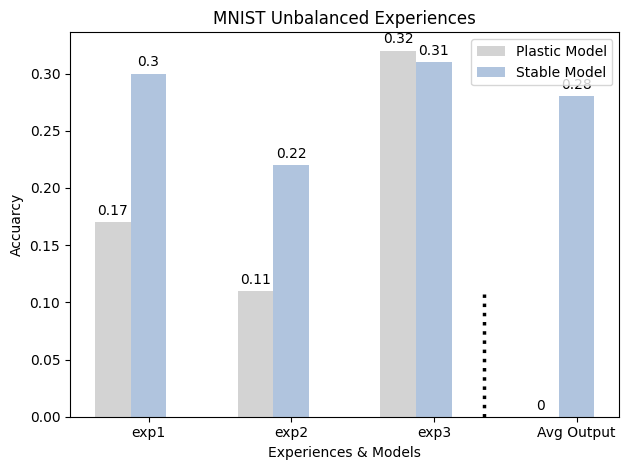

<Figure size 640x480 with 0 Axes>

In [17]:
utility_funcs.barPlotMeanPred(meanPlasticPred, meanStablePred, meanClsOutput, stdStablePred, stdPlasticPred, stdClsOutput)

In [18]:
##########################################################
####### To Plot the reliability plots for calibration
#########################################################

test_temp=[]
total_len = exp2_loaderTest.targets.__len__()
sf = torch.nn.Softmax(dim=1)
for data, labels in DataLoader(exp2_loaderTest, batch_size=total_len):
    test_temp.append(labels.cpu().detach().numpy())

test_y = pd.Series(np.array(np.concatenate(test_temp).ravel().tolist()))
pred_labels = pd.Series(np.array(np.concatenate(pred_labelsST2).ravel().tolist()))
pred_probs = np.concatenate(pred_probsST2, axis=0 )
confidences = sf(torch.tensor(pred_probs)).max(axis=1).values.cpu().detach().numpy()
# pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), numb)
# print(pred_probs)
# empirical_probs = []
# pred_probs_midpoints = []
# print(len(pred_probs_space))

# for i in range(len(pred_probs_space)-1):
    
#     empirical_probs.append(np.mean(test_y[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]))
#     pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

# plt.figure(figsize=(10,4))
# plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
# # plt.title(f"{model_str}", fontsize=20)
# plt.xlabel('predicted prob', fontsize=14)
# plt.ylabel('empirical prob', fontsize=14)

# plt.plot([0,1],[0,1],linestyle='--',color='gray')

# plt.legend(['original', 'ideal'], fontsize=20)

In [19]:
confidences

array([0.21542145, 0.20324506, 0.1739415 , ..., 0.23171598, 0.26218557,
       0.36891085], dtype=float32)

/home/nilay/SynapNet_Project/SynapNet_Algorithm(Main_Implementation)/RealWorldEgWithMNIST/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


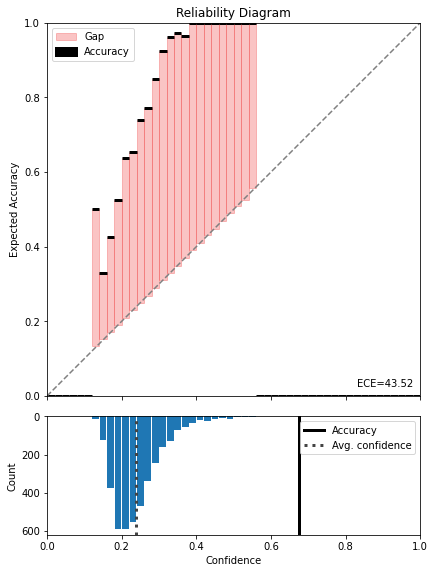

In [20]:
reliability_diagrams.reliability_diagram(true_labels=test_y, pred_labels=pred_labels, 
                                         confidences=confidences, num_bins=50)